<a href="https://colab.research.google.com/github/rpasquini/metodos_cuantitativos/blob/main/notebooks/python/Correlacion_espacial_y_Regresi%C3%B3n_espacial_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_author: Ricardo Pasquini (rpasquini@gmail.com)

In [1]:
!pip install libpysal
!pip install splot
!pip install esda
!pip install spreg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.7/286.7 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.8/322.8 kB 19.5 MB/s eta 0:00:00


In [2]:
import esda
import geopandas as gpd
from libpysal.weights import Queen, Rook, KNN, Kernel, DistanceBand
from splot.libpysal import plot_spatial_weights
import matplotlib.pyplot as plt
from splot.esda import plot_moran
import pandas as pd
import spreg

# Preparamos los datos
Por una limitación de la versión de Colab con la que trabajamos aquí (cantidad de RAM), no podremos correr las medidas espaciales en toda la base de datos, asi que vamos a trabajar con una muestra de datos para CABA.

In [3]:
#departamentos=gpd.GeoDataFrame.from_file("https://github.com/rpasquini/urban-econometrics/blob/master/data/departamentos2019amba.zip?raw=true")
import requests
import zipfile
import io


# 1. Download the zip file
url = "https://github.com/rpasquini/urban-econometrics/blob/master/data/departamentos2019amba.zip?raw=true"
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# 2. Extract the contents of the zip file
zip_file.extractall("/content/")

#3. Leer el shapefile con Geopandas (notar que el archivo ya se encuentra en el directorio de Colab)
departamentos = gpd.read_file('departamentos2019amba.shp')



In [4]:
departamentosCABA=departamentos.loc[departamentos.l2=='Capital Federal']

<Axes: >

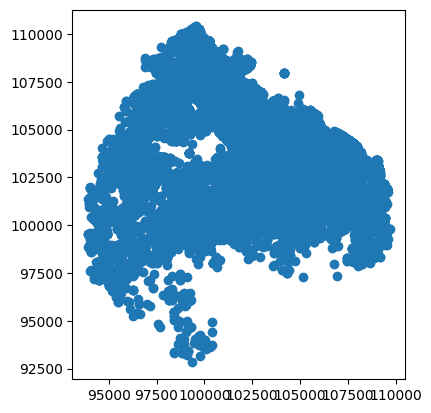

In [5]:
departamentosCABA.plot()

Puesto que algunos de los procesos que vamos toman varios minutos, a los efectos de esta clase, vamos a trabajar con una submuestra aun más pequeña de datos para mostrar ejemplos más rápidamente.

<Axes: >

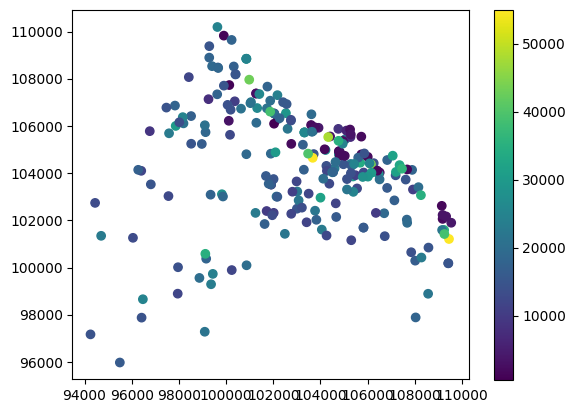

In [11]:
#Tomamos una submuestra de los primeros 500 datos
departamentosCABA2=departamentosCABA.iloc[0:500]

#elimino outliers y missing (nans) para este ejemplo
departamentosCABA2=departamentosCABA2.loc[departamentosCABA2.price<80000]
departamentosCABA2=departamentosCABA2[['price','bedrooms','geometry']].dropna()

#mapeo con plot. La intensidad de los colores está dada por el precio
departamentosCABA2.plot(column='price', legend=True)


In [13]:
# Notar que luego de remover outliers y nans me quedaron 232 observaciones
print(len(departamentosCABA2))

232


<Axes: >

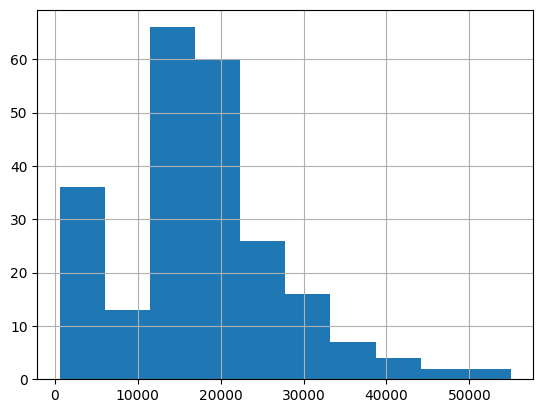

In [21]:
# Examinamos el histograma
departamentosCABA2.price.hist()

# Matriz de pesos espaciales

La matriz de pesos es el objeto que nos sirve para especificar las relaciones (espaciales) entre las observaciones. El contenido de la matriz depende de la forma que definamos para medir la dependencia espacial (ver más en los slides de clase).

Cuando trabajamos con polígonos (por ejemplo partidos o  radios censales) una forma estándar de definir relaciones es basadas en la contiguidad.

En este caso, en cambio, con puntos (resultantes de las coordenadas), vamos a utilizar una medida basada en distancias relativas.

Pysal tiene varias funcionalidades para implementar pesos espaciales. Los pesos por distancia  (DistanceBand) van a considerar la cantidad de vecinos para una distancia determinada. Tener en cuenta también que el threshold tendrá que ser definido de acuerdo a la proyección espacial en la que estén los datos.


En primer lugar construiremos una matriz en base a un theshold de distancia usando DistanceBand. https://pysal.org/libpysal/generated/libpysal.weights.DistanceBand.html#libpysal.weights.DistanceBand

In [12]:
# Con el medodo DistanceBand.from_dataframe de libpysal puedo generar la matriz de weights pasando el geodataframe y usando un threshold (distancia maxima) determinada
wdistance=DistanceBand.from_dataframe(departamentosCABA2, threshold=1000)

/usr/local/lib/python3.11/dist-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 14 islands with ids: 79, 193, 226, 247, 263, 357, 439, 468, 469, 540, 558, 567, 594, 727.
  w = W(neighbors, weights, ids, **kwargs)
/usr/local/lib/python3.11/dist-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 14 islands with ids: 79, 193, 226, 247, 263, 357, 439, 468, 469, 540, 558, 567, 594, 727.
  W.__init__(


In [15]:
# wdistance es un objeto que contiene la matriz de weights. Pero no puedo ver la matriz directamente (además sería muy grande y con muchos 0s)
wdistance

In [19]:
# Para examinar los contenidos tenemos metodos disponibles
# cardinalities me muestra el número de vecinos espaciales (de acuerdo a la definicion que le pase) para cada una de las 232 observaciones
wdistance.cardinalities

{0: 15,
 2: 3,
 4: 4,
 54: 10,
 56: 7,
 57: 11,
 58: 12,
 64: 17,
 67: 24,
 68: 8,
 69: 21,
 70: 21,
 71: 3,
 75: 5,
 77: 12,
 78: 6,
 79: 0,
 81: 10,
 85: 11,
 112: 29,
 117: 8,
 119: 6,
 120: 6,
 121: 6,
 124: 1,
 126: 5,
 134: 1,
 137: 6,
 138: 2,
 164: 11,
 165: 5,
 176: 2,
 177: 16,
 180: 24,
 184: 32,
 186: 15,
 189: 13,
 190: 22,
 191: 13,
 192: 3,
 193: 0,
 194: 15,
 195: 15,
 196: 9,
 197: 15,
 198: 10,
 203: 4,
 206: 2,
 207: 2,
 208: 27,
 209: 32,
 210: 22,
 215: 19,
 226: 0,
 228: 3,
 238: 32,
 239: 26,
 245: 8,
 247: 0,
 248: 3,
 249: 9,
 250: 7,
 252: 5,
 253: 6,
 255: 3,
 256: 8,
 263: 0,
 264: 2,
 296: 6,
 300: 2,
 306: 3,
 309: 3,
 310: 9,
 311: 3,
 314: 8,
 316: 8,
 317: 10,
 318: 10,
 319: 10,
 325: 30,
 326: 31,
 327: 17,
 328: 10,
 329: 25,
 330: 17,
 331: 15,
 333: 13,
 334: 15,
 335: 21,
 336: 23,
 337: 15,
 338: 13,
 339: 17,
 340: 15,
 341: 13,
 342: 15,
 343: 12,
 344: 19,
 346: 26,
 348: 16,
 349: 13,
 350: 9,
 351: 31,
 352: 23,
 354: 12,
 357: 0,
 358: 18,


<Axes: ylabel='Frequency'>

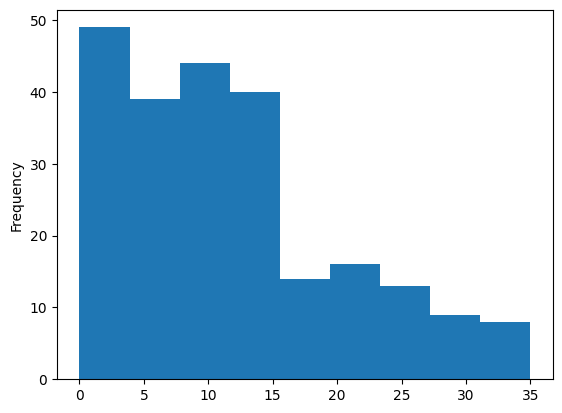

In [25]:
#distanceband.histogram
pd.Series(wdistance.cardinalities).plot.hist(bins=9)

### Representacion gráfica de la matriz de pesos espaciales
En este caso realizamos un ploteo de los vecinos con un gráfico que me conecta a los vecinos

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

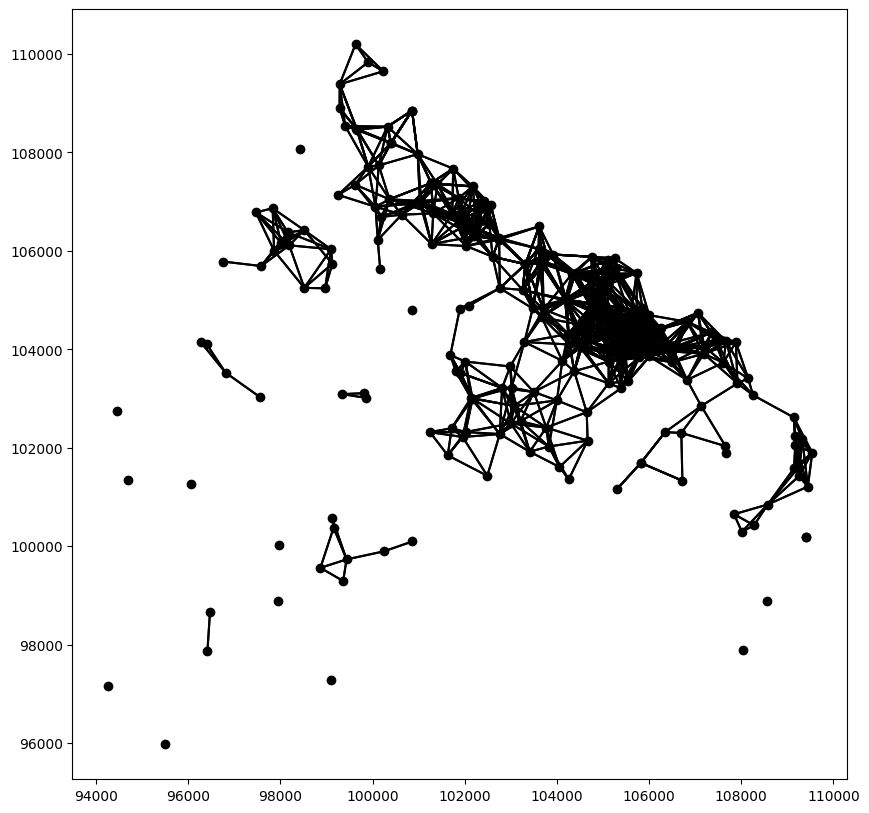

In [26]:
# el método plot permite una representacion grafica
fig, ax = plt.subplots(figsize=(10, 10))
wdistance.plot(departamentosCABA2, ax=ax)

# Estadístico de Moran


El scatterplot de Moran muestra a la variable $y_i$ (eje x) contra su rezago espacial $y^{lag}_i$ (eje y). El rezago espacial es el promedio entre los vecinos espaciales definidos de acuerdo a nuestra matriz de pesos espaciales ($y^{lag}_{i}=\sum w_iy_i$).
El estadistico de Moran es equivalente al coeficiente de la pendiente lineal de la relación.
Su intuición es simple: si hay una relación positiva entre la variable y sus rezagos espaciales es porque hay correlación espacial. (ver slides de clase para más detalle)


In [23]:
# Usando la funcion de esda moran.Moran puedo pasar examinar si los precios están espacialmente relacionados de acuerdo a la matriz de pesos espaciales

mi=esda.moran.Moran(departamentosCABA2.price, wdistance)
mi.I

np.float64(-0.000836643451812438)

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: -0.0', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (-0.0)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

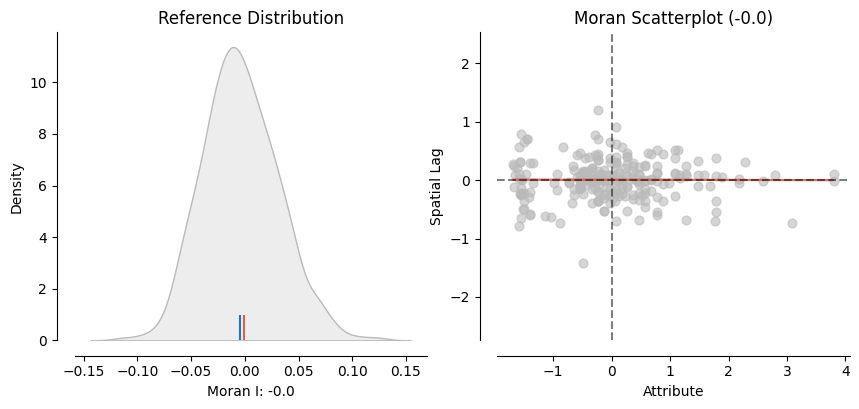

In [24]:
plot_moran(mi, zstandard=True, figsize=(10,4))

## Calculamos los pesos espaciales de otra manera para analizar su efecto

Realizamos un segundo ejemplo, donde vamos a modificar la forma de definir a los vecinos espaciales, y veamos el impacto en términos de la medida de Moran. En este caso vamos a utilizar una forma de identificar vecinos basada en un kernel de distancia. Un kernel de distancia es esencialmente considerar la distancia geografica entre las observaciones, pero aplicarle a esa distancia una función para que las observaciones más alejadas valgan menos hasta llegar a 0 (allí dejan de considerarse vecinos). La función en cuestión puede variar. Aquí utilizamos la función gausiana "gaussian". $$wij = \exp\left( -\frac{1}{2} \left( \frac{d_{ij}}{h} \right)^2 \right) $$
donde:
- $w_{ij}$ es el peso entre las observaciones
- $d_{ij}$ es la distancia entre  *i* y *j*
- $h$ es un parámetro que controla cuan rápido cae el peso con la distancia

In [29]:
kerneldistance = Kernel.from_dataframe(departamentosCABA2, k=10, fixed=False, function='gaussian', diagonal=True)
kerneldistance

(<Figure size 640x480 with 1 Axes>, <Axes: >)

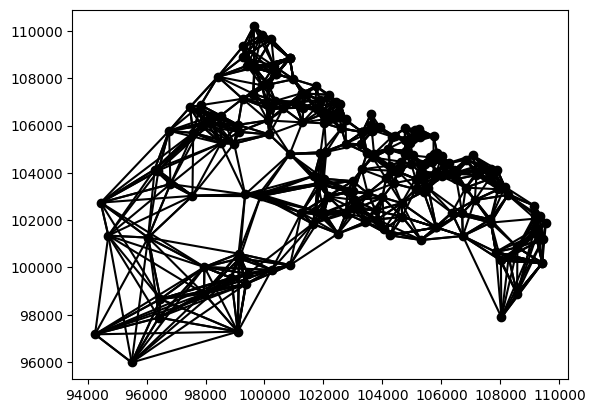

In [30]:
kerneldistance.plot(departamentosCABA2)

In [31]:
mib=esda.moran.Moran(departamentosCABA2.price, kerneldistance)
mib.I

np.float64(0.23876098447825925)

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.24', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.24)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

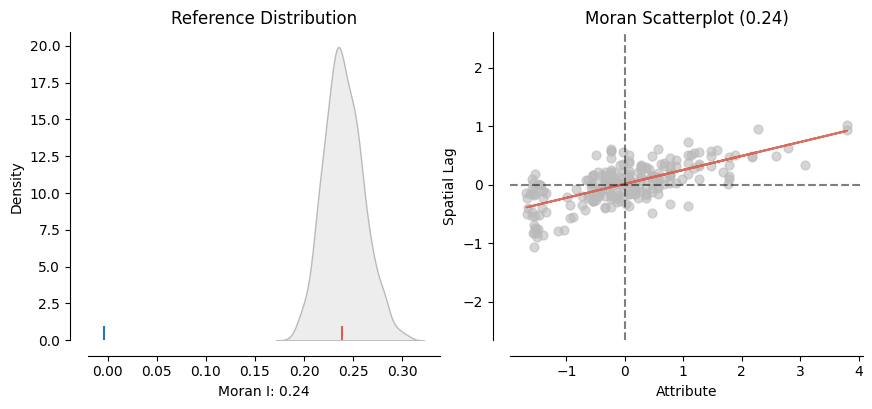

In [33]:
plot_moran(mib, zstandard=True, figsize=(10,4))

# Spatial Regression


Vamos a utilizar spreg para correr un modelo OLS estándar. Luego vamos a examinar si los residuos del modelo presentan un patrón espacial usando Moran

In [34]:
import spreg

el [método OLS de spreg](http://www.pysal.org/spreg/generated/spreg.OLS.html#spreg.OLS) permite correr una regresión OLS pero además correr algunos tests de Moran sobre los residuos


In [35]:
name_y="price"
name_x=["bedrooms"]
results=spreg.OLS(departamentosCABA2.price.values[:, None], departamentosCABA2.bedrooms.values[:, None], w=wdistance, spat_diag=True, moran=True, name_y=name_y, name_x=name_x)

In [36]:
print(results.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       price                Number of Observations:         232
Mean dependent var  :  17318.0172                Number of Variables   :           2
S.D. dependent var  :   9950.5996                Degrees of Freedom    :         230
R-squared           :      0.0012
Adjusted R-squared  :     -0.0032
Sum squared residual: 2.28456e+10                F-statistic           :      0.2696
Sigma-square        :99328499.057                Prob(F-statistic)     :      0.6041
S.E. of regression  :    9966.368                Log likelihood        :   -2464.207
Sigma-square ML     :98472218.893                Akaike info criterion :    4932.414
S.E of regression ML:   9923.3169                Schwarz criterion     :    4939.307

------------------------------------------------------------

In [37]:
print( 'moran', results.moran_res[0])
print( 'standarized value', results.moran_res[1])
print( 'pvalue', results.moran_res[2])

moran 0.00143061110479191
standarized value 0.17057177527364242
pvalue 0.8645604927084939


Veamos que los resultados son identicos que si hubieramos realizado la regresión con statsmodels

In [38]:
import statsmodels.api as sm
Y=departamentosCABA2.price
X=departamentosCABA2.bedrooms
X=sm.add_constant(X)
modelo=sm.OLS(Y,X)
resultados=modelo.fit()
print (resultados.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2696
Date:                Fri, 11 Jul 2025   Prob (F-statistic):              0.604
Time:                        11:53:52   Log-Likelihood:                -2464.2
No. Observations:                 232   AIC:                             4932.
Df Residuals:                     230   BIC:                             4939.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.664e+04   1459.955     11.398      0.0

# Regresión con un lag espacial (2SLS)
$y=\rho Wy+\beta X+\epsilon$ \\
donde el primer termino representa al rezago espacial. \\
$\rho$ es el coeficiente del rezago \\
W es la matriz de pesos espaciales \\
X es la matriz de variables explicativas exógenas.

Documentation(https://pysal.org/spreg/notebooks/GM_Lag_example.html)

In [39]:
name_y="price"
name_x=["bedrooms"]
model = spreg.GM_Lag(departamentosCABA2.price.values[:, None], departamentosCABA2.bedrooms.values[:, None], w=wdistance, name_y=name_y, name_x=name_x)
print(model.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       price                Number of Observations:         232
Mean dependent var  :  17318.0172                Number of Variables   :           3
S.D. dependent var  :   9950.5996                Degrees of Freedom    :         229
Pseudo R-squared    :      0.0000
Spatial Pseudo R-squared:  0.0000

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT     19050.17731      3984.69158         4.78084         0.00000
            bedrooms       403.17552       780.63882         0.51647         0.60553
             W_price        -0.14758      